# Feature Engineering Notebook

## Objectives

*   Engineer features for Regression model


## Inputs

* outputs/datasets/collection/cleaned/house_prices_records_cleaned.csv

## Outputs

* generate a list with variables to engineer

## Conclusions

* log_e transformation seems to improve the QQ plot of GrLivArea, other variables are not significantly improved


  


---

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspaces/heritage-housing/jupyter_notebooks'

We want to make the parent of the current directory the new current directory.
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspaces/heritage-housing'

---

# Load Cleaned Data

In [4]:
import pandas as pd
df_cleaned_path = 'outputs/datasets/collection/cleaned/house_prices_records_cleaned.csv'
df_clean = pd.read_csv(df_cleaned_path)
df_clean.head(3)

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
0,856.0,854.0,3.0,1,706.0,6.0,150.0,548.0,2.0,2003.0,...,8450.0,65.0,196.0,61.0,5,7,856.0,2003,2003,208500
1,1262.0,0.0,3.0,4,978.0,5.0,284.0,460.0,2.0,1976.0,...,9600.0,80.0,0.0,0.0,8,6,1262.0,1976,1976,181500
2,920.0,866.0,3.0,2,486.0,6.0,434.0,608.0,2.0,2001.0,...,11250.0,68.0,162.0,42.0,5,7,920.0,2001,2002,223500


We drop the target variable

In [5]:
df_drop = df_clean.drop('SalePrice', axis=1).copy()
df_drop

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,...,KitchenQual,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd
0,856.0,854.0,3.0,1,706.0,6.0,150.0,548.0,2.0,2003.0,...,4,8450.0,65.0,196.0,61.0,5,7,856.0,2003,2003
1,1262.0,0.0,3.0,4,978.0,5.0,284.0,460.0,2.0,1976.0,...,3,9600.0,80.0,0.0,0.0,8,6,1262.0,1976,1976
2,920.0,866.0,3.0,2,486.0,6.0,434.0,608.0,2.0,2001.0,...,4,11250.0,68.0,162.0,42.0,5,7,920.0,2001,2002
3,961.0,0.0,3.0,1,216.0,5.0,540.0,642.0,1.0,1998.0,...,4,9550.0,60.0,0.0,35.0,5,7,756.0,1915,1970
4,1145.0,0.0,4.0,3,655.0,6.0,490.0,836.0,2.0,2000.0,...,4,14260.0,84.0,350.0,84.0,5,8,1145.0,2000,2000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,953.0,694.0,3.0,1,0.0,1.0,953.0,460.0,2.0,1999.0,...,3,7917.0,62.0,0.0,40.0,5,6,953.0,1999,2000
1456,2073.0,0.0,3.0,1,790.0,5.0,589.0,500.0,1.0,1978.0,...,3,13175.0,85.0,119.0,0.0,6,6,1542.0,1978,1988
1457,1188.0,1152.0,4.0,1,275.0,6.0,877.0,252.0,2.0,1941.0,...,4,9042.0,66.0,0.0,60.0,9,7,1152.0,1941,2006
1458,1078.0,0.0,2.0,2,49.0,4.0,0.0,240.0,1.0,1950.0,...,4,9717.0,68.0,0.0,0.0,6,5,1078.0,1950,1996


### SmartCorrelatedSelection Variables

we look for variables that are correlated with other features and can be dropped

In [6]:
import warnings
from feature_engine.selection import SmartCorrelatedSelection

# Convert the variables to a list
variables = list(df_drop.columns)

# Initialize and fit the SmartCorrelatedSelection
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)
    corr_sel = SmartCorrelatedSelection(variables=variables, method="spearman", threshold=0.6, selection_method="variance")
    corr_sel.fit_transform(df_drop)

# Retrieve the correlated feature sets
corr_sets = [list(feature_set) for feature_set in corr_sel.correlated_feature_sets_]

print(corr_sets)


[['TotalBsmtSF', '1stFlrSF'], ['2ndFlrSF', 'GrLivArea'], ['BsmtFinSF1', 'BsmtFinType1'], ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt'], ['KitchenQual', 'OverallQual']]


We remove these, and also categorical variables, leaving us with the following:

In [7]:
df_drop_2 = df_drop[['BsmtFinSF1', 'BsmtUnfSF', 'GarageArea', 'GrLivArea', 'LotArea', 'LotFrontage', 'MasVnrArea', 'OpenPorchSF', 'TotalBsmtSF']].copy()


In [8]:
df_drop_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   BsmtFinSF1   1460 non-null   float64
 1   BsmtUnfSF    1460 non-null   float64
 2   GarageArea   1460 non-null   float64
 3   GrLivArea    1460 non-null   float64
 4   LotArea      1460 non-null   float64
 5   LotFrontage  1460 non-null   float64
 6   MasVnrArea   1460 non-null   float64
 7   OpenPorchSF  1460 non-null   float64
 8   TotalBsmtSF  1460 non-null   float64
dtypes: float64(9)
memory usage: 102.8 KB


# Feature Engineering

In [9]:
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
from feature_engine import transformation as vt
from feature_engine.outliers import Winsorizer
from feature_engine.encoding import OrdinalEncoder
sns.set(style="whitegrid")
warnings.filterwarnings('ignore')


def FeatureEngineeringAnalysis(df, analysis_type=None):
    """
    - used for quick feature engineering on numerical and categorical variables
    to decide which transformation can better transform the distribution shape
    - Once transformed, use a reporting tool, like pandas-profiling, to evaluate distributions
    """
    check_missing_values(df)
    allowed_types = ['numerical', 'ordinal_encoder', 'outlier_winsorizer']
    check_user_entry_on_analysis_type(analysis_type, allowed_types)
    list_column_transformers = define_list_column_transformers(analysis_type)

    # Loop in each variable and engineer the data according to the analysis type
    df_feat_eng = pd.DataFrame([])
    for column in df.columns:
        # create additional columns (column_method) to apply the methods
        df_feat_eng = pd.concat([df_feat_eng, df[column]], axis=1)
        for method in list_column_transformers:
            df_feat_eng[f"{column}_{method}"] = df[column]

        # Apply transformers in respective column_transformers
        df_feat_eng, list_applied_transformers = apply_transformers(
            analysis_type, df_feat_eng, column)

        # For each variable, assess how the transformations perform
        transformer_evaluation(
            column, list_applied_transformers, analysis_type, df_feat_eng)

    return df_feat_eng


def check_user_entry_on_analysis_type(analysis_type, allowed_types):
    """ Check analysis type """
    if analysis_type is None:
        raise SystemExit(
            f"You should pass analysis_type parameter as one of the following options: {allowed_types}")
    if analysis_type not in allowed_types:
        raise SystemExit(
            f"analysis_type argument should be one of these options: {allowed_types}")


def check_missing_values(df):
    if df.isna().sum().sum() != 0:
        raise SystemExit(
            f"There is a missing value in your dataset. Please handle that before getting into feature engineering.")


def define_list_column_transformers(analysis_type):
    """ Set suffix columns according to analysis_type"""
    if analysis_type == 'numerical':
        list_column_transformers = [
            "log_e", "log_10", "reciprocal", "power", "box_cox", "yeo_johnson"]

    elif analysis_type == 'ordinal_encoder':
        list_column_transformers = ["ordinal_encoder"]

    elif analysis_type == 'outlier_winsorizer':
        list_column_transformers = ['iqr']

    return list_column_transformers


def apply_transformers(analysis_type, df_feat_eng, column):
    for col in df_feat_eng.select_dtypes(include='category').columns:
        df_feat_eng[col] = df_feat_eng[col].astype('object')

    if analysis_type == 'numerical':
        df_feat_eng, list_applied_transformers = FeatEngineering_Numerical(
            df_feat_eng, column)

    elif analysis_type == 'outlier_winsorizer':
        df_feat_eng, list_applied_transformers = FeatEngineering_OutlierWinsorizer(
            df_feat_eng, column)

    elif analysis_type == 'ordinal_encoder':
        df_feat_eng, list_applied_transformers = FeatEngineering_CategoricalEncoder(
            df_feat_eng, column)

    return df_feat_eng, list_applied_transformers


def transformer_evaluation(column, list_applied_transformers, analysis_type, df_feat_eng):
    # For each variable, assess how the transformations perform
    print(f"* Variable Analyzed: {column}")
    print(f"* Applied transformation: {list_applied_transformers} \n")
    for col in [column] + list_applied_transformers:

        if analysis_type != 'ordinal_encoder':
            DiagnosticPlots_Numerical(df_feat_eng, col)

        else:
            if col == column:
                DiagnosticPlots_Categories(df_feat_eng, col)
            else:
                DiagnosticPlots_Numerical(df_feat_eng, col)

        print("\n")


def DiagnosticPlots_Categories(df_feat_eng, col):
    plt.figure(figsize=(4, 3))
    sns.countplot(data=df_feat_eng, x=col, palette=[
                  '#432371'], order=df_feat_eng[col].value_counts().index)
    plt.xticks(rotation=90)
    plt.suptitle(f"{col}", fontsize=30, y=1.05)
    plt.show()
    print("\n")


def DiagnosticPlots_Numerical(df, variable):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    sns.histplot(data=df, x=variable, kde=True, element="step", ax=axes[0])
    stats.probplot(df[variable], dist="norm", plot=axes[1])
    sns.boxplot(x=df[variable], ax=axes[2])

    axes[0].set_title('Histogram')
    axes[1].set_title('QQ Plot')
    axes[2].set_title('Boxplot')
    fig.suptitle(f"{variable}", fontsize=30, y=1.05)
    plt.tight_layout()
    plt.show()



def FeatEngineering_CategoricalEncoder(df_feat_eng, column):
    list_methods_worked = []
    try:
        encoder = OrdinalEncoder(encoding_method='arbitrary', variables=[
                                 f"{column}_ordinal_encoder"])
        df_feat_eng = encoder.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_ordinal_encoder")

    except Exception:
        df_feat_eng.drop([f"{column}_ordinal_encoder"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked


def FeatEngineering_OutlierWinsorizer(df_feat_eng, column):
    list_methods_worked = []

    # Winsorizer iqr
    try:
        disc = Winsorizer(
            capping_method='iqr', tail='both', fold=1.5, variables=[f"{column}_iqr"])
        df_feat_eng = disc.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_iqr")
    except Exception:
        df_feat_eng.drop([f"{column}_iqr"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked


def FeatEngineering_Numerical(df_feat_eng, column):
    list_methods_worked = []

    # LogTransformer base e
    try:
        lt = vt.LogTransformer(variables=[f"{column}_log_e"])
        df_feat_eng = lt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_log_e")
    except Exception:
        df_feat_eng.drop([f"{column}_log_e"], axis=1, inplace=True)

    # LogTransformer base 10
    try:
        lt = vt.LogTransformer(variables=[f"{column}_log_10"], base='10')
        df_feat_eng = lt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_log_10")
    except Exception:
        df_feat_eng.drop([f"{column}_log_10"], axis=1, inplace=True)

    # ReciprocalTransformer
    try:
        rt = vt.ReciprocalTransformer(variables=[f"{column}_reciprocal"])
        df_feat_eng = rt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_reciprocal")
    except Exception:
        df_feat_eng.drop([f"{column}_reciprocal"], axis=1, inplace=True)

    # PowerTransformer
    try:
        pt = vt.PowerTransformer(variables=[f"{column}_power"])
        df_feat_eng = pt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_power")
    except Exception:
        df_feat_eng.drop([f"{column}_power"], axis=1, inplace=True)

    # BoxCoxTransformer
    try:
        bct = vt.BoxCoxTransformer(variables=[f"{column}_box_cox"])
        df_feat_eng = bct.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_box_cox")
    except Exception:
        df_feat_eng.drop([f"{column}_box_cox"], axis=1, inplace=True)

    # YeoJohnsonTransformer
    try:
        yjt = vt.YeoJohnsonTransformer(variables=[f"{column}_yeo_johnson"])
        df_feat_eng = yjt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_yeo_johnson")
    except Exception:
        df_feat_eng.drop([f"{column}_yeo_johnson"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked


## Dealing with Feature Engineering

### Numerical Transformation

* Variable Analyzed: BsmtFinSF1
* Applied transformation: ['BsmtFinSF1_power', 'BsmtFinSF1_yeo_johnson'] 



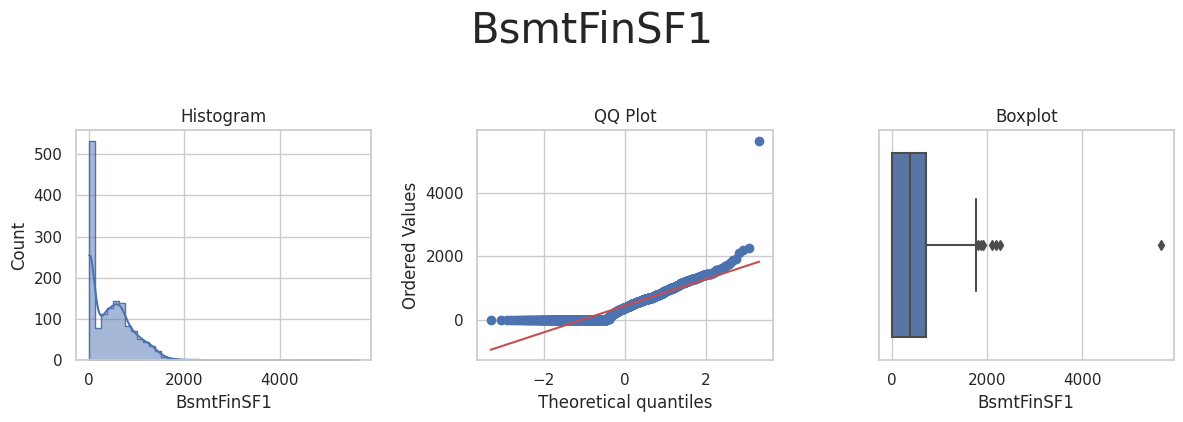

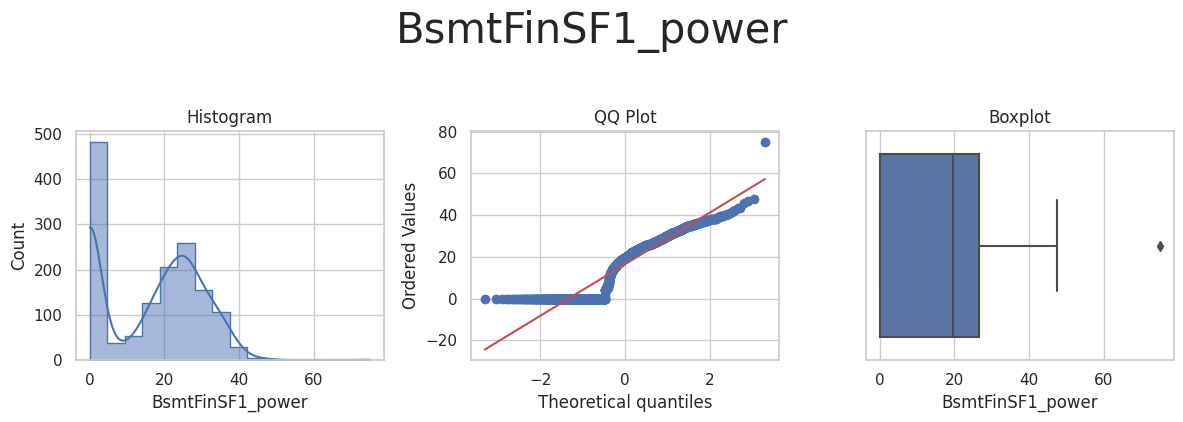

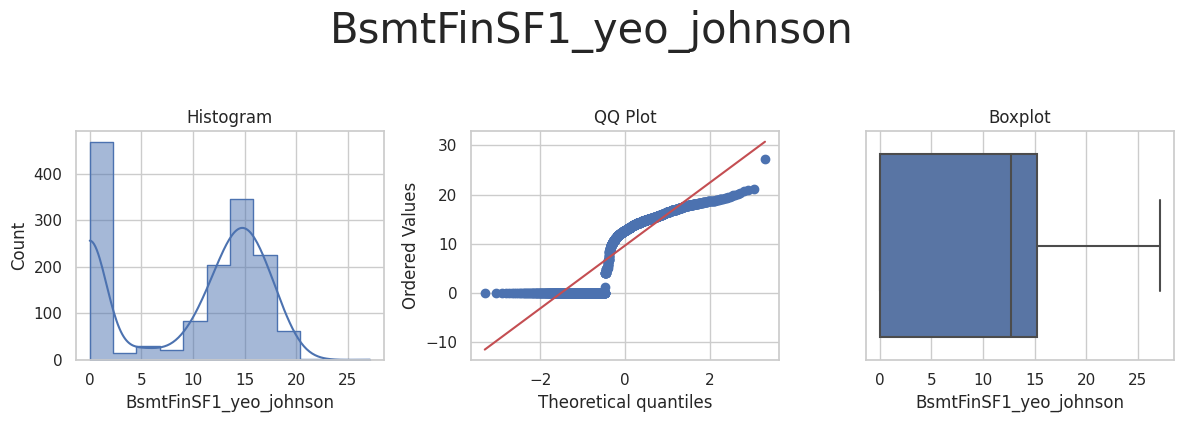



* Variable Analyzed: BsmtUnfSF
* Applied transformation: ['BsmtUnfSF_power', 'BsmtUnfSF_yeo_johnson'] 



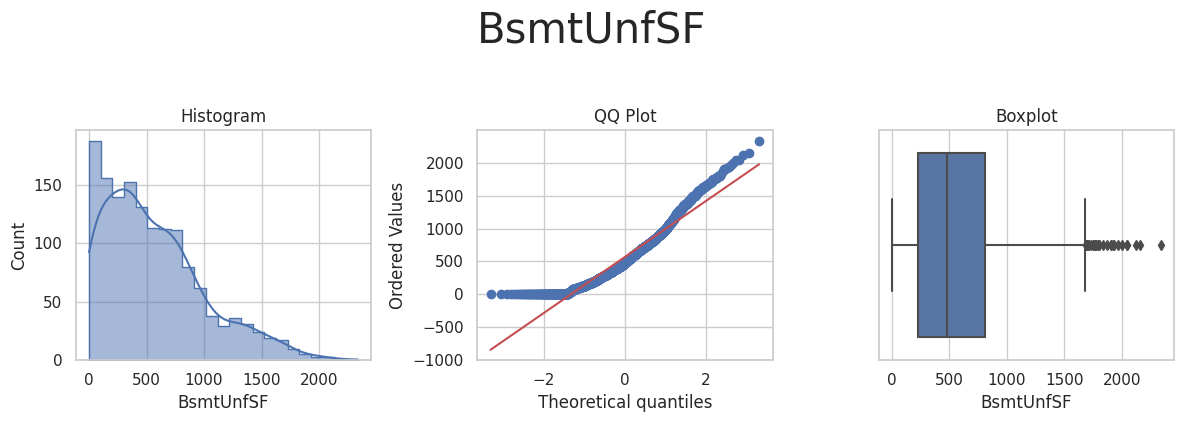

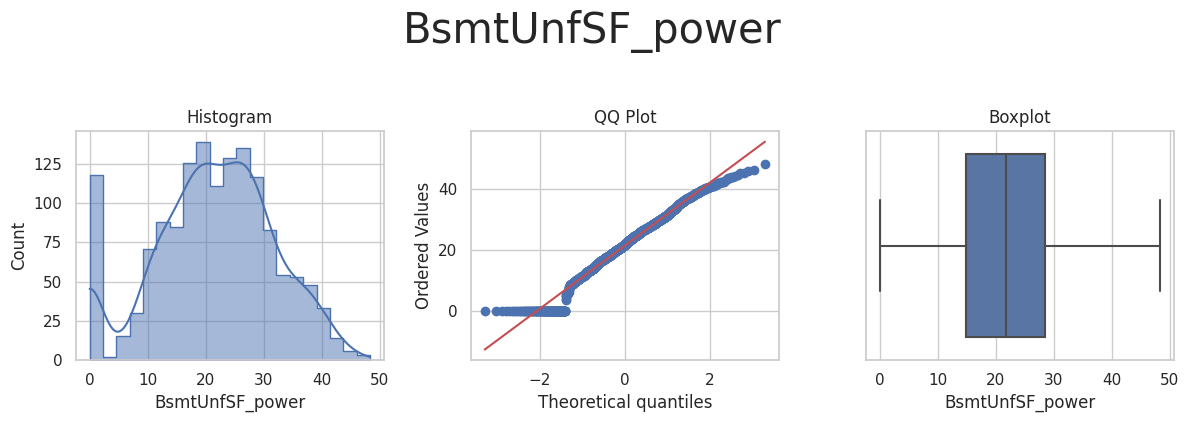

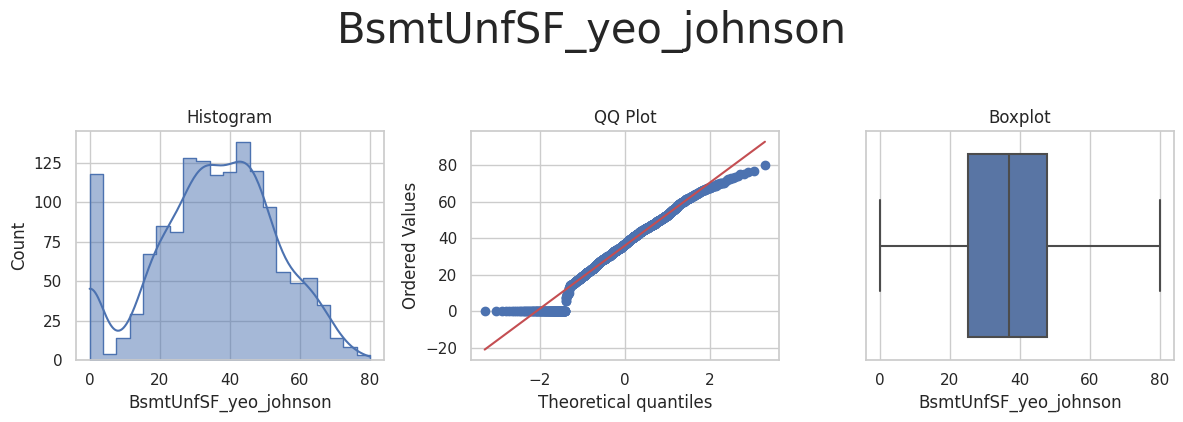



* Variable Analyzed: GarageArea
* Applied transformation: ['GarageArea_power', 'GarageArea_yeo_johnson'] 



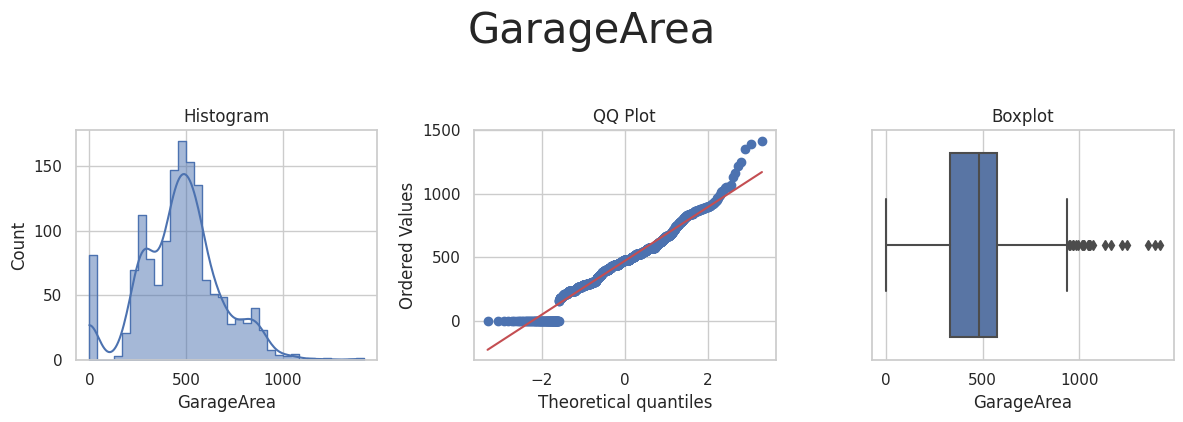

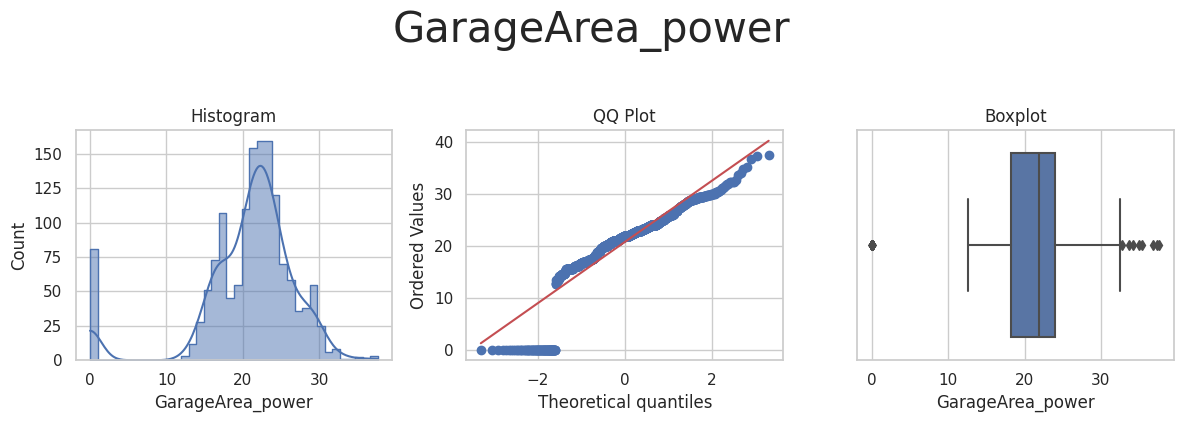

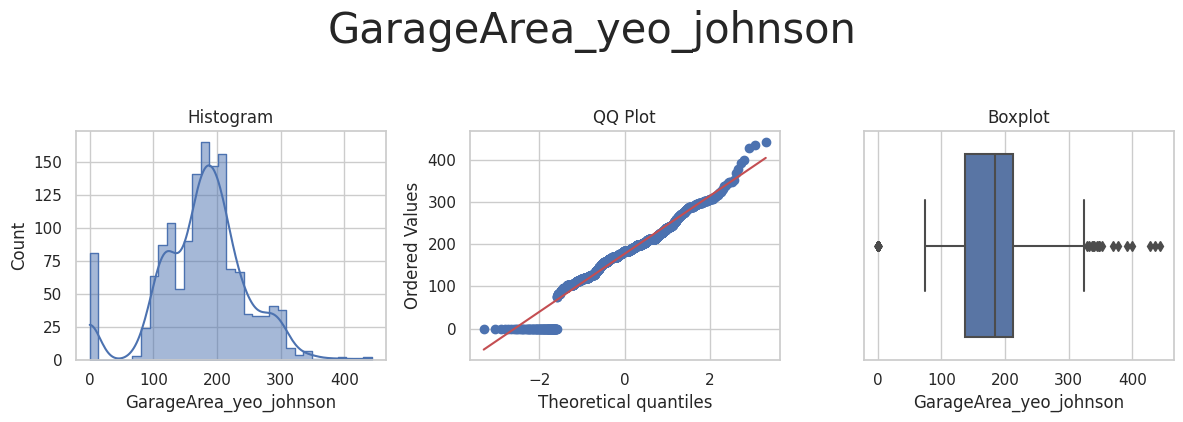



* Variable Analyzed: GrLivArea
* Applied transformation: ['GrLivArea_log_e', 'GrLivArea_log_10', 'GrLivArea_reciprocal', 'GrLivArea_power', 'GrLivArea_box_cox', 'GrLivArea_yeo_johnson'] 



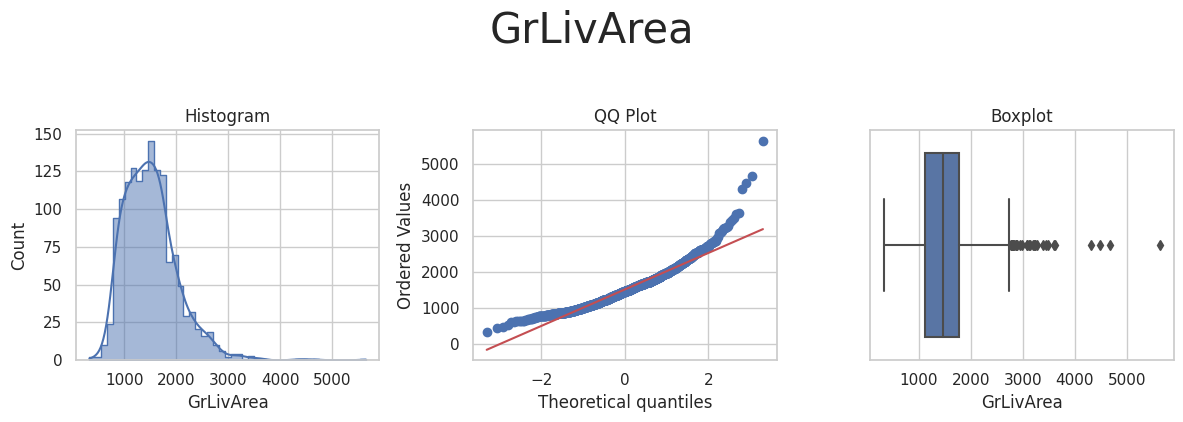

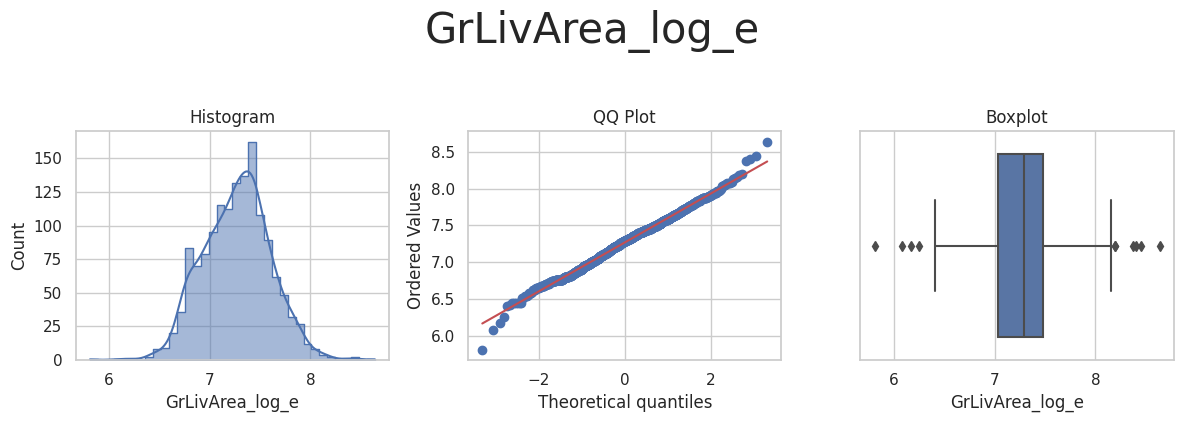

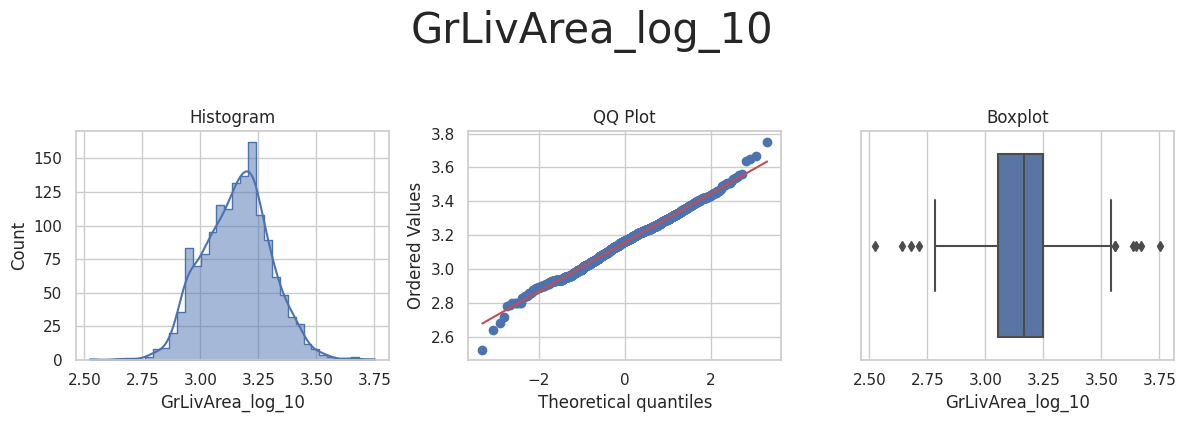

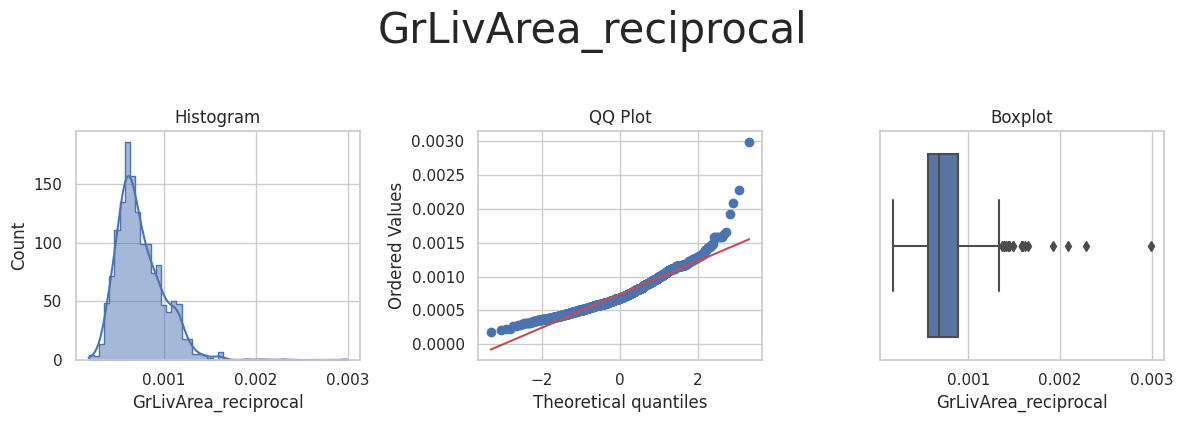

In [ ]:
df_feat_eng = FeatureEngineeringAnalysis(df=df_drop_2, analysis_type='numerical')

# Display the analysis for each variable
for column in df_feat_eng.columns:
    transformer_evaluation
    

Conclusion:
* log_e transformation seems to improve the QQ plot of GrLivArea, other variables are not significantly improved

---